<h1><font color="#008800">Python aplicado a la Gestión de Carteras</font></h1>

# GENERACION DE PRECIOS DE UNO O VARIOS ACTIVOS

In [1]:
import numpy as np
import pandas as pd
import pandas_market_calendars as mcal
import matplotlib.pyplot as plt
import seaborn as sns

from utils import dibuja_covar

plt.style.use('ggplot')

Vamos a generar los precios de dos activos dados por:

* valores medios
* volatilidades
* correlación

Primero vamos a generar los retornos para formar carteras de dos activos. Para ello, vamos a generar un rango de fechas para las simulaciones. Utilizaremos los días hábiles de la bolsa de Nueva York.

In [7]:
# Número de días
num_dias = 1000
start_date = "2010-01-01"
end_date = "2100-01-01"

nyse = mcal.get_calendar('XNYS') # Mercado de nueva york
schedule = nyse.schedule(start_date=start_date, end_date=end_date)
business_days = schedule.index[:num_dias]

Ahora definimos los parámetros de los activos. Debemos definir la media y desviación estandar de los dos activos y su correlación.

In [8]:
# Parámetros de los activos
med1 = 0.03/252  # Media del primer activo
std1 = 0.1/np.sqrt(252)  # Desviación estándar del primer activo

med2 = 0.1/252  # Media del segundo activo
std2 = 0.2/np.sqrt(252)  # Desviación estándar del segundo activo

corr12 = 0.4  # Coeficiente de correlación entre los dos activos

Podemos generar los retornos de los activos generando números aleatorios usando la distribución normal.

**Observación**: Recuerda que los retornos no siguen una distribución normal

In [9]:
np.random.seed(103)
ret_df = pd.DataFrame(index=business_days)
ret_df['Activo1'] = np.random.normal(med1, std1, num_dias)
ret_df['Activo2'] = np.random.normal(med2, std2, num_dias)

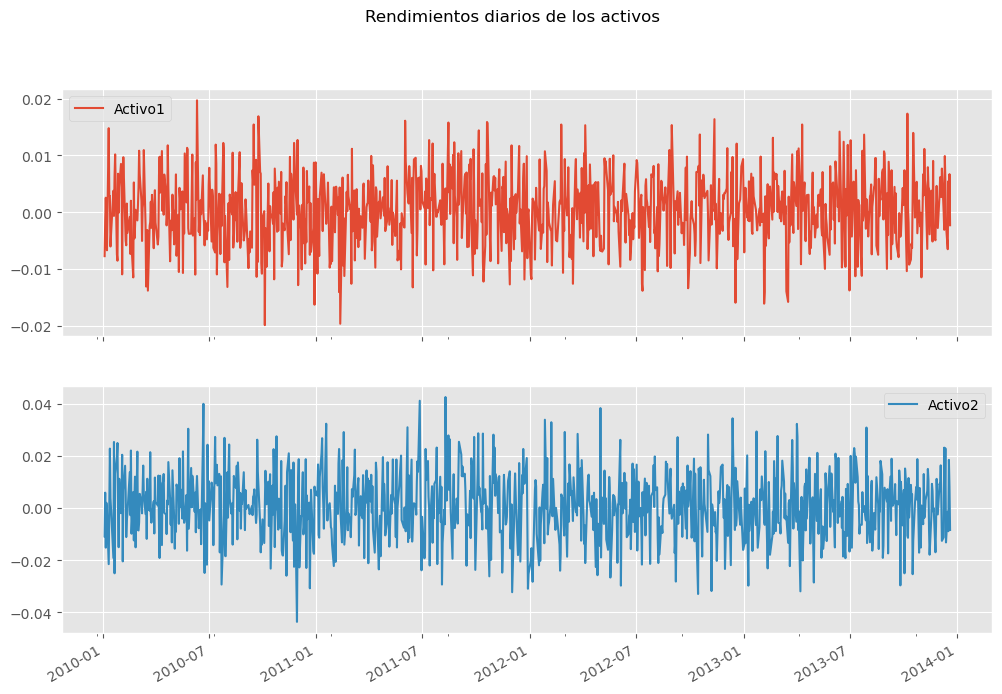

In [11]:
ret_df.plot(figsize=(12, 8), subplots=True, title='Rendimientos diarios de los activos', grid=True)
plt.show()

**NOTA CHRIS: ¿Por qué cumprod de 1 + ret_df? No debería ser cumsum porque son retornos logaritmicos?**

<Axes: title={'center': 'Precios de los activos'}>

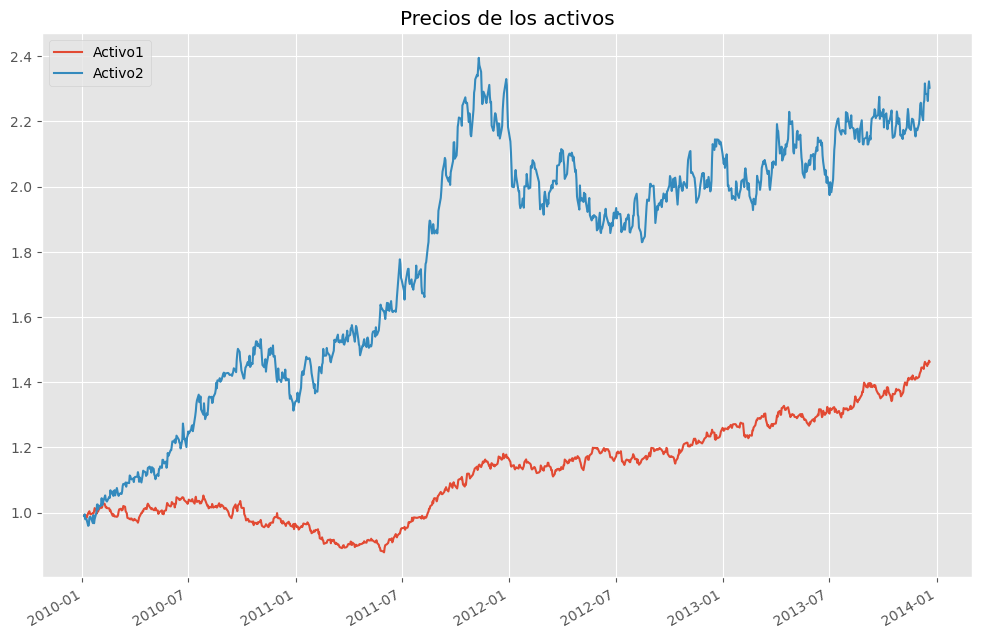

In [16]:
precios_df = (1 + ret_df).cumprod()

precios_df.plot(figsize=(12, 8), title='Precios de los activos', grid=True)

**Observación:** estos retornos no tienen en cuenta la correlación entre los activos.

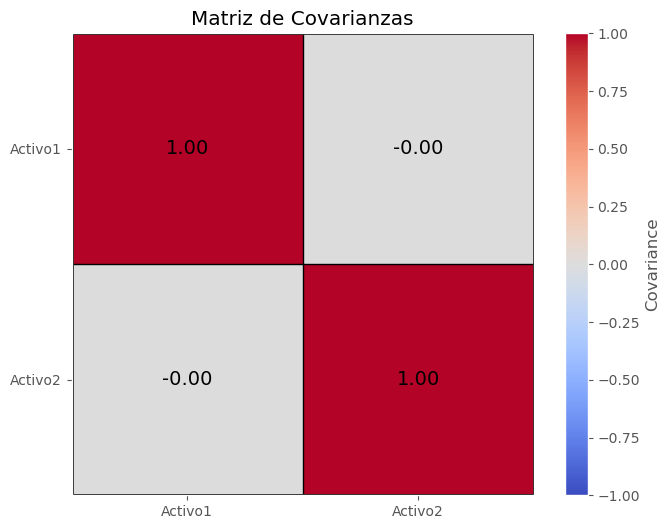

In [21]:
mat_corr = ret_df.corr()
dibuja_covar(mat_corr)
plt.show()

**CONCLUSIÓN**: 

* Los retornos de los activos no tienen en cuenta la correlación entre los activos. 

* Si usamos estos retornos para formar carteras, no tendremos en cuenta la correlación entre los activos.

---

Con el siguiente código generamos retornos siguiendo una matriz de covarianzas utilizando la función **np.random.multivariate_normal** de `numpy`.

In [22]:
# Código generar retornos siguiendo matriz covarianzas

import numpy as np

# Ejemplo de una matriz de covarianzas para 3 activos
matriz_covarianzas = np.array([[0.1, 0.05, 0.03],
                               [0.05, 0.2, 0.06],
                               [0.03, 0.06, 0.15]])

# Verificar si la matriz es positiva semi-definida
if np.all(np.linalg.eigvals(matriz_covarianzas) >= 0):
    print("La matriz es positiva semi-definida.")
else:
    print("La matriz no es positiva semi-definida. Ajuste los valores.")

# Número de simulaciones
n_simulaciones = 1000

# Generar retornos aleatorios
retornos_simulados = np.random.multivariate_normal(
    mean=[0, 0, 0],  # Media de los retornos, asumiendo media cero para simplificar
    cov=matriz_covarianzas,
    size=n_simulaciones
)

print("Retornos simulados:")
print(retornos_simulados)


La matriz es positiva semi-definida.
Retornos simulados:
[[-0.31400891 -0.96948575 -0.12510912]
 [-0.14405025 -0.40044518 -0.33441916]
 [-0.13663344 -0.52293671  0.10567983]
 ...
 [-0.44883384  0.27160969 -0.20355172]
 [-0.26943249 -0.92028183 -0.14509871]
 [-0.37135357 -0.72777341  0.35934312]]


Ahora vamos a usar la correlación entre los activos para generar los retornos de los activos. Para ello, generamos una matriz de correlación entre los activos y generamos los retornos de los activos usando la matriz de correlación con la función `multivariate_normal` de `numpy`.

**NOTA CHRIS: Me parece un código bastante enreversado. ¿Quizás estaría bien poner unas ecuaciones para entender las funciones?**

In [23]:
def generar_datos(n_activos=10, rango_medias=(0, 0.1), rango_std=(0.05, 0.3), tipo_correlacion="poco"):
    """
    Genera datos aleatorios de medias, desviaciones estándar y coeficientes de correlación para un número 
    dado de activos.
    
    Parámetros:
    - n_activos: Número de activos.
    - rango_medias: Rango (min, max) para las medias de los activos.
    - rango_std: Rango (min, max) para las desviaciones estándar de los activos.
    - tipo_correlacion: Tipo de correlación deseada ("positiva", "negativa", "poco" o "mixto").
    
    Retorna:
    - medias: Array con las medias de los activos.
    - desviaciones: Array con las desviaciones estándar de los activos.
    - corr_mat: Matriz de correlación de los activos.
    """

    # Tratamiento de errores
    if not isinstance(n_activos, int) or n_activos <= 0:
        raise ValueError("El número de activos debe ser un entero positivo.")
    
    if not (isinstance(rango_medias, (list, tuple)) and len(rango_medias) == 2 and rango_medias[0] < rango_medias[1]):
        raise ValueError("El rango de medias debe ser una tupla o lista con dos valores, donde el primero es menor que el segundo.")
    
    if not (isinstance(rango_std, (list, tuple)) and len(rango_std) == 2 and rango_std[0] < rango_std[1]):
        raise ValueError("El rango de desviaciones estándar debe ser una tupla o lista con dos valores, donde el primero es menor que el segundo.")
    
    if tipo_correlacion not in ["positiva", "negativa", "poco", "mixto"]:
        raise ValueError("El tipo de correlación no es válido. Debe ser 'positiva', 'negativa', 'poco' o 'mixto'.")
        
    # Generar medias aleatorias dentro del rango especificado
    medias = np.random.uniform(rango_medias[0], rango_medias[1], n_activos)
    
    # Generar desviaciones estándar aleatorias dentro del rango especificado
    desviaciones = np.random.uniform(rango_std[0], rango_std[1], n_activos)
    
    # Generar una matriz de correlación aleatoria
    A = np.random.randn(n_activos, n_activos)
    cov_temp = A @ A.T
    d = np.sqrt(np.diag(cov_temp))
    corr_mat = cov_temp / d[:, None] / d[None, :]
    
    # Ajustar la matriz de correlación según el tipo deseado
    if tipo_correlacion == "positiva":
        corr_mat = 0.5 * (corr_mat + 1)
    elif tipo_correlacion == "negativa":
        corr_mat = 0.5 * (corr_mat - 1)
    elif tipo_correlacion == "mixto":
        # Definir los índices para dividir en tres grupos
        idx1 = n_activos // 3
        idx2 = 2 * n_activos // 3
        
        # Activos del primer grupo: correlación positiva
        corr_mat[:idx1, :idx1] = 0.5 * (corr_mat[:idx1, :idx1] + 1)
        
        # Activos del segundo grupo: correlación negativa
        corr_mat[idx1:idx2, idx1:idx2] = 0.5 * (corr_mat[idx1:idx2, idx1:idx2] - 1)
        
        # Activos del tercer grupo: poco correlacionados (no se modifica)
    # Si es "poco", no hacemos ajustes porque la matriz ya es poco correlacionada
    
    # Asegurar que los valores diagonales de la matriz de correlación sean 1
    np.fill_diagonal(corr_mat, 1)
    
    return medias, desviaciones, corr_mat

In [24]:
def calcular_matriz_covarianza(media_lst, std_lst, corr_mat):
    """
    Calcula la matriz de covarianza a partir de listas de medias, desviaciones estándar y una matriz de correlación.

    Parámetros:
    - media_lst: Lista de medias esperadas.
    - std_lst: Lista de desviaciones estándar.
    - corr_mat: Matriz de correlación. Tipo numpy array de tamaño (n, n), donde n es el número de activos.

    Retorna:
    - Matriz de covarianza: numpy array de tamaño (n, n), donde n es el número de activos.
    """
    
    # Comprobar que las listas de medias y desviaciones estándar tienen la misma longitud
    if len(media_lst) != len(std_lst):
        raise ValueError("Las listas de medias y desviaciones estándar deben tener la misma longitud.")
    
    # Almacenar la longitud de las listas para futuras comprobaciones
    n = len(media_lst)
    
    # Comprobar que la matriz de correlación tiene la forma correcta
    if corr_mat.shape != (n, n):
        raise ValueError("La matriz de correlación debe ser cuadrada y de tamaño igual a la longitud de las listas de medias y desviaciones estándar.")
    
    # Comprobar que la matriz de correlación es simétrica
    if not np.allclose(corr_mat, corr_mat.T):
        raise ValueError("La matriz de correlación debe ser simétrica.")
    
    # Calcular la matriz de covarianza usando la matriz de correlación y las desviaciones estándar
    # Se utiliza np.outer para obtener el producto externo de las desviaciones estándar, que nos da una matriz
    # cuyos elementos son el producto de las desviaciones estándar correspondientes. 
    # Esta matriz se multiplica elemento por elemento con la matriz de correlación.
    cov_mat = corr_mat * np.outer(std_lst, std_lst)
    
    return cov_mat



In [25]:
def es_matriz_covarianza(mat):
    """
    Comprueba si una matriz dada es una matriz de covarianza.
    
    Parámetros:
    - mat: Matriz a verificar. Tipo numpy array de tamaño (n, n), donde n es el número de activos.
    
    Retorna:
    - True si la matriz es de covarianza, False en caso contrario.
    """
    # Comprobar simetría
    if not np.allclose(mat, mat.T):
        return False
    
    # Comprobar que todos los valores propios son no negativos (semi-definida positiva)
    eigenvalues = np.linalg.eigvalsh(mat)
    if np.any(eigenvalues < 0):
        return False
    
    # Comprobar que los elementos de la diagonal son no negativos
    if np.any(np.diag(mat) < 0):
        return False
    
    return True

In [26]:
def ajustar_correlacion(cov_mat, tipo_correlacion="poco", factor=0.5):
    """
    Ajusta la matriz de covarianza para que los activos estén más correlacionados positivamente, 
    más correlacionados negativamente o menos correlacionados, basándose en un factor.
    
    Parámetros:
    - cov_mat: Matriz de covarianza original. Tipo numpy array de tamaño (n, n), donde n es el número de activos.
    - tipo_correlacion: Tipo de correlación deseada ("positiva", "negativa" o "poco").
    - factor: Factor de ajuste en el rango [-1, 1] para determinar la intensidad del ajuste.
    
    Retorna:
    - Matriz de covarianza ajustada.
    """
    
    # Comprobar si la matriz dada es de covarianza
    if not es_matriz_covarianza(cov_mat):
        raise ValueError("La matriz dada no es una matriz de covarianza válida.")
    
    # Convertir la matriz de covarianza en una matriz de correlación
    d = np.sqrt(np.diag(cov_mat))
    corr_mat = cov_mat / d[:, None] / d[None, :]
    
    # Ajustar la matriz de correlación según el tipo y factor deseado
    if tipo_correlacion == "positiva":
        corr_mat += factor * (1 - corr_mat)
    elif tipo_correlacion == "negativa":
        corr_mat += factor * (-1 - corr_mat)
    elif tipo_correlacion == "poco":
        # Multiplicar las correlaciones por un factor menor que 1 (p. ej., 0.2) para reducirlas hacia 0
        mask = np.ones_like(corr_mat) - np.eye(corr_mat.shape[0])
        corr_mat *= factor * mask + np.eye(corr_mat.shape[0])
    else:
        raise ValueError("El tipo de correlación debe ser 'positiva', 'negativa' o 'poco'.")
    
    # Asegurar que los valores diagonales sean 1
    np.fill_diagonal(corr_mat, 1)
    
    # Convertir la matriz de correlación ajustada de nuevo en una matriz de covarianza
    cov_mat_ajustada = corr_mat * d[:, None] * d[None, :]
    
    return cov_mat_ajustada

In [27]:
# genera un rango de fechas hábiles

def generate_business_dates(num_dias, start_date, calendar='XNYS'):
    """
    Genera un rango de fechas hábiles para un mercado especificado.

    Parámetros:
    - num_dias: Número de días hábiles deseados.
    - start_date: Fecha de inicio del rango.
    - calendar: Calendario del mercado deseado (por defecto, 'XNYS' para el NYSE).

    Retorna:
    - Un rango de fechas hábiles.
    """
    
    # Tratamiento de errores
    if not isinstance(num_dias, int) or num_dias <= 0:
        raise ValueError("El número de días debe ser un entero positivo.")
    
    try:
        current_date = pd.Timestamp(start_date)
    except:
        raise ValueError("La fecha de inicio no es válida.")
    
    if calendar not in mcal.get_calendar_names():
        raise ValueError(f"El calendario '{calendar}' no está disponible.")
    
    # Crear un calendario para el mercado especificado
    market_cal = mcal.get_calendar(calendar)
    
    # Inicializar una variable para contar los días laborables
    business_days_count = 0
    
    # Inicializar la fecha de inicio
    current_date = pd.Timestamp(start_date)
    
    # Mientras no se alcance el número deseado de días laborables
    while business_days_count < num_dias:
        # Verificar si la fecha actual es un día laborable
        if market_cal.valid_days(start_date=current_date, end_date=current_date).size > 0:
            business_days_count += 1
        current_date += pd.DateOffset(days=1)  # Avanzar al siguiente día natural

    dias_naturales = current_date - pd.Timestamp(start_date)
    
    # Generar un rango de fechas de días hábiles
    business_days = market_cal.valid_days(start_date=start_date, end_date=start_date + pd.DateOffset(days=dias_naturales.days))
    
    return business_days




#### Evento bajista 

Simular un evento de mercado negativo implica ajustar las medias, volatilidades y matriz de covarianza de manera que reflejen un comportamiento de mercado más bajista. A continuación, propongo una función que realiza estos ajustes:

- **Medias (med_lst)**: Disminuir las medias de retorno esperadas. Esto refleja la expectativa de menores retornos o incluso retornos negativos durante un evento bajista.

- **Volatilidades (std_lst)**: Aumentar las volatilidades. Durante eventos de mercado negativos, generalmente hay más incertidumbre y, por lo tanto, mayor volatilidad.

- **Matriz de Covarianza (cov_mat)**: Aumentar las correlaciones en la matriz de covarianza. En tiempos de crisis o eventos bajistas, los activos tienden a moverse juntos (es decir, tienen correlaciones más altas).

In [28]:
def simular_evento_bajista(med_lst, std_lst, cov_mat, impacto_medias=0.2, impacto_vol=0.3, impacto_corr=0.5):
    """
    Simula un evento de mercado bajista ajustando las medias, volatilidades y matriz de covarianza.

    Parámetros:
    - med_lst: Lista de medias originales.
    - std_lst: Lista de volatilidades originales.
    - cov_mat: Matriz de covarianza original.
    - impacto_medias: Proporción para disminuir las medias (por defecto, 0.2 o 20%).
    - impacto_vol: Proporción para aumentar las volatilidades (por defecto, 0.3 o 30%).
    - impacto_corr: Proporción para aumentar las correlaciones (por defecto, 0.5 o 50%).

    Retorna:
    - med_lst_ajustada: Lista de medias ajustadas.
    - std_lst_ajustada: Lista de volatilidades ajustadas.
    - cov_mat_ajustada: Matriz de covarianza ajustada.
    """
    
    # Ajustar medias
    med_lst_ajustada = [med * (1 - impacto_medias) for med in med_lst]
    
    # Ajustar volatilidades
    std_lst_ajustada = [std * (1 + impacto_vol) for std in std_lst]
    
    # Ajustar matriz de covarianza: aumentar correlaciones y volatilidades
    d = np.sqrt(np.diag(cov_mat))
    corr_mat = cov_mat / d[:, None] / d[None, :]
    corr_mat_ajustada = corr_mat + impacto_corr * (1 - corr_mat)
    np.fill_diagonal(corr_mat_ajustada, 1)
    cov_mat_ajustada = corr_mat_ajustada * np.outer(std_lst_ajustada, std_lst_ajustada)
    
    return med_lst_ajustada, std_lst_ajustada, cov_mat_ajustada


#### Impacto bajista severo

Si queremos simular un impacto tan severo en el mercado que incluso los activos que estaban creciendo pasen a tener pérdidas, debemos aplicar cambios más drásticos a las medias, volatilidades y matriz de covarianza. Aquí hay una estrategia:

-  **Medias (med_lst)**: Establecer todas las medias a valores negativos, garantizando pérdidas. Podríamos hacer esto tomando el valor absoluto negativo de las medias originales y luego aplicar un factor adicional para aumentar la severidad.

- **Volatilidades (std_lst)**: Aumentar las volatilidades aún más que en el escenario anterior, reflejando una gran incertidumbre en el mercado.

- **Matriz de Covarianza (cov_mat)**: Aumentar las correlaciones en la matriz de covarianza aún más que en el escenario anterior, ya que en eventos de crisis severa, es común que todos los activos reaccionen de manera similar.

In [29]:
def simular_impacto_severo(med_lst, std_lst, cov_mat, factor_medias=1.5, factor_vol=0.5, factor_corr=0.7):
    """
    Simula un impacto severo en el mercado ajustando las medias, volatilidades y matriz de covarianza.

    Parámetros:
    - med_lst: Lista de medias originales.
    - std_lst: Lista de volatilidades originales.
    - cov_mat: Matriz de covarianza original.
    - factor_medias: Factor para aumentar la severidad de las pérdidas (por defecto, 1.5).
    - factor_vol: Proporción para aumentar las volatilidades (por defecto, 0.5 o 50%).
    - factor_corr: Proporción para aumentar las correlaciones (por defecto, 0.7 o 70%).

    Retorna:
    - med_lst_ajustada: Lista de medias ajustadas.
    - std_lst_ajustada: Lista de volatilidades ajustadas.
    - cov_mat_ajustada: Matriz de covarianza ajustada.
    """
    
    # Ajustar medias a valores negativos
    med_lst_ajustada = [-abs(med) * factor_medias for med in med_lst]
    
    # Ajustar volatilidades
    std_lst_ajustada = [std * (1 + factor_vol) for std in std_lst]
    
    # Ajustar matriz de covarianza: aumentar correlaciones y volatilidades
    d = np.sqrt(np.diag(cov_mat))
    corr_mat = cov_mat / d[:, None] / d[None, :]
    corr_mat_ajustada = corr_mat + factor_corr * (1 - corr_mat)
    np.fill_diagonal(corr_mat_ajustada, 1)
    cov_mat_ajustada = corr_mat_ajustada * np.outer(std_lst_ajustada, std_lst_ajustada)
    
    return med_lst_ajustada, std_lst_ajustada, cov_mat_ajustada


#### Evento impacto bajista parcial

Un impacto en el mercado donde algunos activos pasen a perder y otros no.

Una forma de hacerlo sería seleccionar aleatoriamente una proporción de activos y ajustar sus medias para que reflejen pérdidas, mientras que el resto de los activos no se ve afectado o lo hace en menor medida.

Vamos a diseñar la función:

- **Medias (med_lst)**: Seleccionar aleatoriamente una proporción de activos y ajustar sus medias para que sean negativas. Los demás activos pueden mantener sus medias o recibir un impacto menor.

- **Volatilidades (std_lst)**: Aumentar las volatilidades, ya que en un escenario de impacto, incluso si algunos activos no están perdiendo, la incertidumbre puede aumentar.


- **Matriz de Covarianza (cov_mat)**: Aumentar las correlaciones, pero en menor medida que en un evento de impacto severo.

In [30]:
def simular_impacto_bajista_parcial(med_lst, std_lst, cov_mat, prop_affected=0.5, factor_medias=1.5, factor_vol=0.3, factor_corr=0.5):
    """
    Simula un impacto parcial en el mercado donde algunos activos pasan a perder y otros no.

    Parámetros:
    - med_lst: Lista de medias originales.
    - std_lst: Lista de volatilidades originales.
    - cov_mat: Matriz de covarianza original.
    - prop_affected: Proporción de activos que se verán afectados negativamente (por defecto, 0.5 o 50%).
    - factor_medias: Factor para aumentar la severidad de las pérdidas de los activos afectados (por defecto, 1.5).
    - factor_vol: Proporción para aumentar las volatilidades (por defecto, 0.3 o 30%).
    - factor_corr: Proporción para aumentar las correlaciones (por defecto, 0.5 o 50%).

    Retorna:
    - med_lst_ajustada: Lista de medias ajustadas.
    - std_lst_ajustada: Lista de volatilidades ajustadas.
    - cov_mat_ajustada: Matriz de covarianza ajustada.
    """
    
    # Seleccionar aleatoriamente los activos que se verán afectados
    num_affected = int(len(med_lst) * prop_affected)
    affected_indices = np.random.choice(len(med_lst), num_affected, replace=False)
    
    # Ajustar medias
    med_lst_ajustada = med_lst.copy()
    for idx in affected_indices:
        med_lst_ajustada[idx] = -abs(med_lst[idx]) * factor_medias
    
    # Ajustar volatilidades
    std_lst_ajustada = [std * (1 + factor_vol) for std in std_lst]
    
    # Ajustar matriz de covarianza: aumentar correlaciones
    d = np.sqrt(np.diag(cov_mat))
    corr_mat = cov_mat / d[:, None] / d[None, :]
    corr_mat_ajustada = corr_mat + factor_corr * (1 - corr_mat)
    np.fill_diagonal(corr_mat_ajustada, 1)
    cov_mat_ajustada = corr_mat_ajustada * np.outer(std_lst_ajustada, std_lst_ajustada)
    
    return med_lst_ajustada, std_lst_ajustada, cov_mat_ajustada



#### Evento paso a mercado lateral

Un **mercado lateral** (o "ranging") es aquel en el que los precios se mueven dentro de un rango horizontal sin una tendencia clara al alza o a la baja durante un período de tiempo prolongado.

Si deseas simular el paso de un mercado bajista o alcista a uno lateral, los ajustes típicos serían:

- **Medias (med_lst)**: Reducir las medias hacia cero para reflejar la falta de una tendencia clara. Esto no significa que todos los retornos sean exactamente cero, sino que la expectativa general es que no haya un movimiento significativo en una dirección particular.

- **Volatilidades (std_lst)**: Dependiendo de la naturaleza del mercado lateral, las volatilidades pueden disminuir (en un mercado muy tranquilo) o mantenerse (en un mercado volátil pero sin dirección).

- **Matriz de Covarianza (cov_mat)**: Las correlaciones podrían disminuir, ya que en un mercado sin una dirección clara, los activos podrían moverse más independientemente.

In [31]:
def simular_mercado_lateral(med_lst, std_lst, cov_mat, factor_medias=0.5, factor_vol=0.7, factor_corr=0.5):
    """
    Simula el paso a un mercado lateral ajustando las medias, volatilidades y matriz de covarianza.

    Parámetros:
    - med_lst: Lista de medias originales.
    - std_lst: Lista de volatilidades originales.
    - cov_mat: Matriz de covarianza original.
    - factor_medias: Factor para reducir las medias hacia cero (por defecto, 0.5).
    - factor_vol: Proporción para ajustar las volatilidades (por defecto, 0.7 o 70%).
    - factor_corr: Proporción para reducir las correlaciones (por defecto, 0.5 o 50%).

    Retorna:
    - med_lst_ajustada: Lista de medias ajustadas.
    - std_lst_ajustada: Lista de volatilidades ajustadas.
    - cov_mat_ajustada: Matriz de covarianza ajustada.
    """
    
    # Ajustar medias hacia cero
    med_lst_ajustada = [med * factor_medias for med in med_lst]
    
    # Ajustar volatilidades
    std_lst_ajustada = [std * factor_vol for std in std_lst]
    
    # Ajustar matriz de covarianza: reducir correlaciones
    d = np.sqrt(np.diag(cov_mat))
    corr_mat = cov_mat / d[:, None] / d[None, :]
    corr_mat_ajustada = corr_mat - factor_corr * corr_mat
    np.fill_diagonal(corr_mat_ajustada, 1)
    cov_mat_ajustada = corr_mat_ajustada * np.outer(std_lst_ajustada, std_lst_ajustada)
    
    return med_lst_ajustada, std_lst_ajustada, cov_mat_ajustada


#### Evento mercado alcista


Un mercado alcista ("bullish market") es aquel en el que los precios de los activos tienden a subir o se espera que suban durante un período prolongado.

Si deseamos simular un mercado alcista, los ajustes típicos serían:

- **Medias (med_lst)**: Aumentar las medias para reflejar expectativas de retornos más altos.

- **Volatilidades (std_lst)**: Las volatilidades pueden aumentar o disminuir dependiendo de la naturaleza del mercado alcista.
Un mercado alcista tranquilo y constante podría ver reducciones en la volatilidad, mientras que un mercado alcista impulsado por un gran optimismo podría tener una volatilidad más alta.

- **Matriz de Covarianza (cov_mat)**: Las correlaciones podrían aumentar, ya que en un mercado alcista fuerte, es común que muchos activos se muevan en la misma dirección.

In [32]:
def simular_mercado_alcista(med_lst, std_lst, cov_mat, factor_medias=1.5, factor_vol=1.2, factor_corr=0.5):
    """
    Simula un mercado alcista ajustando las medias, volatilidades y matriz de covarianza.

    Parámetros:
    - med_lst: Lista de medias originales.
    - std_lst: Lista de volatilidades originales.
    - cov_mat: Matriz de covarianza original.
    - factor_medias: Factor para aumentar las medias (por defecto, 1.5).
    - factor_vol: Proporción para ajustar las volatilidades (por defecto, 1.2 o 20% de aumento).
    - factor_corr: Proporción para aumentar las correlaciones (por defecto, 0.5 o 50% de aumento).

    Retorna:
    - med_lst_ajustada: Lista de medias ajustadas.
    - std_lst_ajustada: Lista de volatilidades ajustadas.
    - cov_mat_ajustada: Matriz de covarianza ajustada.
    """
    
    # Ajustar medias hacia arriba
    med_lst_ajustada = [med * factor_medias for med in med_lst]
    
    # Ajustar volatilidades
    std_lst_ajustada = [std * factor_vol for std in std_lst]
    
    # Ajustar matriz de covarianza: aumentar correlaciones
    d = np.sqrt(np.diag(cov_mat))
    corr_mat = cov_mat / d[:, None] / d[None, :]
    corr_mat_ajustada = corr_mat + factor_corr * (1 - corr_mat)
    np.fill_diagonal(corr_mat_ajustada, 1)
    cov_mat_ajustada = corr_mat_ajustada * np.outer(std_lst_ajustada, std_lst_ajustada)
    
    return med_lst_ajustada, std_lst_ajustada, cov_mat_ajustada


In [ ]:
n_activos = 10
med_min = -0.2/252
med_max = 0.2/252
std_min = 0.05/np.sqrt(252)
std_max = 0.3/np.sqrt(252)

In [ ]:
mu_lst, desv_last, cov_mat = generar_datos(n_activos=n_activos, rango_medias=(med_min, med_max), rango_std=(std_min, std_max), tipo_correlacion="poco")

In [ ]:
dibuja_covar(pd.DataFrame(cov_mat))

In [ ]:
dibuja_covar(pd.DataFrame(ajustar_correlacion(cov_mat, tipo_correlacion="poco", factor=0.1)))

In [ ]:
def generate_returns(med_lst, std_lst, corr_lst, start_date, num_dias):
    """
    Genera un DataFrame de retornos simulados para un conjunto de activos.

    Parámetros:
    - med_lst: Lista con las rentabilidades esperadas de los activos.
    - std_lst: Lista con las desviaciones estándar de los activos.
    - corr_lst: Lista con las correlaciones de los activos respecto al primer activo.
    - start_date: Fecha de inicio de la simulación.
    - num_dias: Número de días de la simulación.

    Retorna:
    - Un DataFrame con los retornos simulados.
    
    Errores:
    - Lanza un error si las longitudes de med_lst y std_lst no son las mismas.
    - Lanza un error si la longitud de corr_lst no es correcta.
    """
    
    if len(med_lst) != len(std_lst):
        raise ValueError("Las listas med_lst y std_lst deben tener la misma longitud.")
    
    if len(corr_lst) != len(med_lst) * (len(med_lst) - 1) // 2:
        raise ValueError(f"La longitud de corr_lst debe ser {len(med_lst)*(len(med_lst)-1)//2}.")
    
    num_activos = len(med_lst)
    cov_matrix = np.diag(std_lst)**2  # Rellenar la diagonal con las varianzas
    
    # Rellenar la matriz de covarianza usando capacidades de vectorización
    corr_matrix = np.ones((num_activos, num_activos))
    corr_matrix[np.triu_indices(num_activos, 1)] = corr_lst
    corr_matrix += corr_matrix.T - np.diag(np.diag(corr_matrix))
    cov_matrix = np.outer(std_lst, std_lst) * corr_matrix

    print(cov_matrix)

    business_days = generate_business_dates(num_dias, start_date)
    returns = np.random.multivariate_normal(med_lst, cov_matrix, num_dias)
    column_names = [f"Activo{i+1}" for i in range(num_activos)]
    returns_df = pd.DataFrame(returns, index=business_days, columns=column_names)
    
    return returns_df


In [ ]:
# Generamos la matriz de covarianza
cov_matrix = np.array([[std1**2, corr12 * std1 * std2],
                       [corr12 * std1 * std2, std2**2]])

# Generamos los retornos
returns = np.random.multivariate_normal([med1, med2], cov_matrix, num_dias)

In [ ]:
returns_corr_df = pd.DataFrame(returns, index=business_days, columns=['Activo1', 'Activo2'])

In [ ]:
mat_corr_si = returns_corr_df.corr()
dibuja_covar(mat_corr_si)

In [ ]:
precios_corr_df = (1 + returns_corr_df).cumprod()

precios_corr_df.plot(figsize=(12, 8), title='Precios de los activos', grid=True)

In [ ]:
num_act = 10
num_dias = 1000
med_min = 0.01/252
med_max = 0.15/252
std_min = 0.05/np.sqrt(252)
std_max = 0.2/np.sqrt(252)

med = np.random.uniform(med_min, med_max, num_act)
std = np.random.uniform(std_min, std_max, num_act)

#Ordenamos para que el de mayor rentabilidad tenga el mayor riesgo
med.sort()
std.sort()

In [ ]:
# Generar retornos diarios
np.random.seed(0)  # Fijar la semilla para reproducibilidad

# Generamos la matriz de covarianza
cov_matrix = np.array([[std1**2, corr12 * std1 * std2],
                       [corr12 * std1 * std2, std2**2]])

# Generamos los retornos
returns = np.random.multivariate_normal([med1, med2], cov_matrix, num_dias)

In [ ]:
# Creamos un DataFrame de Pandas con los retornos y las fechas como índice
returns_df = pd. DataFrame(returns, columns=['Activo 1', 'Activo 2'], index=business_days)

# Convierte el 'DatetimeIndex' en una columna 'fecha' con solo la fecha
returns_df['fecha'] = returns_df.index.date

# Luego, crea un nuevo 'DatetimeIndex' usando la columna 'fecha'
returns_df.index = pd.to_datetime(returns_df['fecha'])

# Ahora puedes eliminar la columna 'fecha' si lo deseas
returns_df.drop('fecha', axis=1, inplace=True)

returns_df.head(2)

Comprobamos que los retornos tienen la correlación deseada

In [ ]:
print(f' El coeficiente de correlación de los retornos es {returns_df.corr().iloc[0, 1]:.4f} y el esperado es {corr12}')

In [ ]:
df_precios = 1 + returns_df.cumsum()
#precios_ini = np.array([117, 158])
#df_precios = precios_ini * df_precios

In [ ]:
#hacemos una gráfica de los precios
df_precios.plot(figsize=(12, 6))
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.title('Precios de los activos')
plt.show()


In [ ]:
plt.scatter(returns_df['Activo 1'], returns_df['Activo 2'], alpha=0.5)

In [ ]:
med1 = 0.2/252
std1 = 0.3/np.sqrt(252)

med2 = 0.03/252
std2 = 0.1/np.sqrt(252)

corr12 = 0

num_dias = 1000

In [ ]:
# Generar retornos diarios
np.random.seed(0)  # Fijar la semilla para reproducibilidad

# Generamos la matriz de covarianza
cov_matrix = np.array([[std1**2, corr12 * std1 * std2],
                       [corr12 * std1 * std2, std2**2]])

# Generamos los retornos
returns = np.random.multivariate_normal([med1, med2], cov_matrix, num_dias)

In [ ]:
print(f' El coeficiente de correlación de los retornos es {np.corrcoef(returns[:, 0], returns[:, 1])[0, 1]:.4f} y el esperado es {corr12}')

In [ ]:
df_precios = 1 + returns.cumsum(axis=0)
df_precios = pd.DataFrame(df_precios, columns=['Activo 1', 'Activo 2'])

# Crear un DataFrame con una fila que tenga el valor 1 para todas las columnas
df_first_row = pd.DataFrame([[1, 1]], columns=['Activo 1', 'Activo 2'])

# Concatenar el DataFrame con la fila de valor 1 con df_precios
df_precios = pd.concat([df_first_row, df_precios]).reset_index(drop=True)

df_precios = df_precios.iloc[:-1, :]

precios_ini = np.array([117, 158])

df_precios = precios_ini * df_precios

df_precios.index = business_days




df_precios.plot(figsize=(12, 6), legend=False)

In [ ]:
df_precios.to_csv('../data/precios_corr_cero.csv')

In [ ]:
df_precios.corr()

In [ ]:
plt.scatter(returns[:, 0], returns[:, 1], alpha=0.5)

In [ ]:
def genera_retornos(med, desv, correl, num_dias):
    """
    Genera una matriz de retornos diarios para un conjunto de activos.
    :param medias: Vector de medias anuales de los activos
    :param desviaciones: Vector de desviaciones estándar anuales de los activos
    :param correlaciones: Vector de correlaciones entre el primer activo y los demás. El primer valor debe ser 1.0
    :param num_dias: Número de días para los que se generarán los retornos
    :return: Matriz de retornos diarios
    """

        # Verificar que medias, desviaciones y correlaciones tengan la misma longitud
    if len(med) != len(desv) or len(med) != len(correl):
        raise ValueError("Las listas de medias, desviaciones y correlaciones deben tener la misma longitud.")
    
    med /= 252
    desv /= np.sqrt(252)

    # Resto del código para generar los retornos
    num_activos = len(med)
 
    # Inicializa una matriz de covarianzas vacía de dimensiones n x n
    cov_matrix = np.zeros((num_activos, num_activos))

    # Llena la diagonal principal con las varianzas de cada activo
    cov_matrix[np.arange(num_activos), np.arange(num_activos)] = desv**2

       # Llena el resto de la matriz con los productos de desviaciones y correlaciones
    for i in range(1, num_activos):
        for j in range(i):
            cov_matrix[i, j] = desv[i] * desv[0] * correl[i]
            cov_matrix[j, i] = cov_matrix[i, j]
    
    returns = np.random.multivariate_normal(med, cov_matrix, num_dias)

    return returns

In [ ]:
# Número de días
num_dias = 1000

medias = np.array([0.10, -0.12, -0.05, -0.001, 0.006, 0, 0.15])

# Desviaciones estándar de cada activo (reemplaza con tus valores)
desviaciones = np.array([0.20, 0.23, 0.07, 0.1, 0.003, 0.07, 0.03])

# Valores de correlación del primer activo con los demás activos (reemplaza con tus valores)
correlaciones = np.array([1.0, -1, -0.8, -0.2, 0, 0.5, 1])

In [ ]:
ret_array = genera_retornos(medias, desviaciones, correlaciones, num_dias)

In [ ]:
columnas = []

for i in range(len(medias)):
    columnas.append(f'Activo_{i+1}')

returns_df = pd.DataFrame(ret_array, columns=columnas)

In [ ]:
dibuja_covar(returns_df.corr())

In [ ]:
precios_ini = [78, 82, 103, 98, 101, 89, 110]

df_precios = 1 + returns_df.cumsum()

df_precios = precios_ini * df_precios

df_precios.index = business_days

df_precios.index = df_precios.index.date

In [ ]:
df_precios.head(2)

In [ ]:
#hacemos una gráfica de los precios
df_precios.plot(figsize=(12, 6))
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.title('Precios de los activos')
plt.show()

# precios_ini = np.array([117, 158])
# df_precios = precios_ini * df_precios